# ML framework collection applied to "Titanic" Kaggle dataset

### Table of contents: 
1. [Import libraries & files](#1)
    - [1.1. Useful functions](#1.1.)
2. [Get descriptive info on raw data](#2)
    - [2.1. Pandas Profiling Report](#2ppr)
3. [Raw data exploratory data analysis & visualization](#3)
4. [Clean data: eliminate NaN & transform non-classifiable features](#4)
5. [Transform classifiable feature values to ints](#5)
6. [Engineer new features](#6)
7. [Train ML models, tune hyperparams & evaluate](#7)
    - [7.1. Look at preprocessed training data info](#7.1.)
    - [7.2. Prepare train & test datasets for model training](#7.2.)
    - [7.3 Train the models](#7.3.)
    - [7.4. Score the models](#7.4.)
    - [7.5. K-Fold Cross Validation](#7.5.)
    - [7.6. Feature importance](#7.6.)
    - [7.7. Random Forest 2nd test (after removing unimportant features)](#7.7.)
    - [7.8. Out of bag samples (instead of K-fold CV) to eval RF classifier](#7.8.)
    - [7.9. Hyperparameter Tuning](#7.9.)
    - [7.10. Test model with best_params_ from GridSearchCV](#7.10.)
    - [7.11. Evaluate model with Confusion Matrix](#7.11.)
    - [7.12. Precision and Recall](#7.12.)
    - [7.13. F-Score](#7.13.)
    - [7.14. Precision Recall Curve](#7.14.)
    - [7.15. ROC AUC Curve](#7.15.)
    - [7.16. Potential next steps to improve score](#7.16.)
8. [Export output to csv & submit](#8)
8. [Important non-obvious lessons](#9)
10. [References](#10)

### ML frameworks featured in 7.3: 
- [Decision Tree](#dt)
- [Random Forest Classifier](#rf)
- [Linear Support Vector Machine](#lsvm)
- [Support Vector Machine Classifier](#svm)
- [Logistic Regression](#lr)
- [K Nearest Neighbors](#knn)
- [Gaussian Naive Bayes](#nb)
- [Perceptron](#p)
- [Stockastic Gradient Descent (SGD)](#sgd)
- [DEEP LEARNING: TF, Keras](#dl)
    - [TensorFlow](#tf)
    - [Keras](#k)
- [Gradient Boosting](#gb)
- [XGBoost](#xgb)
- [LightGBM](#lgbm)
- [ENSEMBLE LEARNING: Bagging, Boosting, Stacking](#ensemble)
    - [Stacking](#stacking)


**Researcher: Vladislav Semin**

### Subheader formatting:
<div class="alert alert-block alert-info">
<b>Takeaways</b> are highlighted in ***blue***

<div class="alert alert-block alert-warning">  
- ***TO DO's*** to improve predictions are highlighted in ***yellow***

<div id="1"></div>
# 1. Import libraries & files 

In [1]:
# import libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pandas_profiling

# data visualization
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import style  
        
# ML Algorithms
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split

from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from vecstack import stacking
from sklearn import tree

from xgboost import XGBClassifier
import lightgbm as lgb
from lightgbm import LGBMModel,LGBMClassifier


import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras import optimizers
from keras.wrappers.scikit_learn import KerasClassifier

import tensorflow as tf

import torch
import torch.nn as nn
import torch.nn.functional as F

# ignore warnings
import warnings
warnings.filterwarnings('ignore')
        
# Results written to current directory are saved as output

Using TensorFlow backend.


In [2]:
# Input data files are available in the "../input/" directory.
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# create data handles
train_data = pd.read_csv("/kaggle/input/titanic/train.csv")
test_data = pd.read_csv("/kaggle/input/titanic/test.csv")

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/gender_submission.csv
/kaggle/input/titanic/test.csv


<div id="1.1."></div>
### 1.1. Useful functions 

In [3]:
# here we create a useful function to display all important confusion matrix metrics
def display_confusion_matrix(target, prediction, score=None):
    cm = metrics.confusion_matrix(target, prediction)
    plt.figure(figsize=(6,6))
    sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square=True, cmap='Blues_r')
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    if score:
        score_title = 'Accuracy Score: {0}'.format(round(score, 5))
        plt.title(score_title, size = 14)
    classification_report = pd.DataFrame.from_dict(metrics.classification_report(target, prediction, output_dict=True))
    display(classification_report.round(2))

<div id="2"></div>
# 2. Get descriptive info on raw data

<div class="alert alert-block alert-warning">  
- ***TO DO:*** fill-in MISSING VALUES for age, cabin, embarked features - DONE below
- ***TO DO:*** convert sex, cabin, embarked TO CLASSIFIABLE values - DONE below
- ***TO DO:*** GROUP VALUES of certain features - DONE below

In [4]:
train_data.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [5]:

test_data.head(5)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [6]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [7]:
## another way to see the percentage of missing vals in each category
total = train_data.isnull().sum().sort_values(ascending=False)
percent_1 = train_data.isnull().sum()/train_data.isnull().count()*100
percent_2 = (round(percent_1, 1)).sort_values(ascending=False)
missing_data = pd.concat([total, percent_2], axis=1, keys=['Total', '%'])
missing_data.head(5)

,Total,%
Cabin,687,77.1
Age,177,19.9
Embarked,2,0.2
Fare,0,0.0
Ticket,0,0.0


In [8]:
# we see there are missing values
train_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


<div id="2ppr"></div>
### 2.1. Pandas Profiling Report

In [9]:
%%time
train_data.profile_report()

CPU times: user 16.1 s, sys: 9.33 s, total: 25.4 s
Wall time: 14.9 s


<div id="3"></div>
# 3. Raw data exploratory data analysis & visualization

<div class="alert alert-block alert-info">
<b>Takeaway:</b> Raw data EDA is the fastest way to generate first feature hypotheses

### Correlation matrix

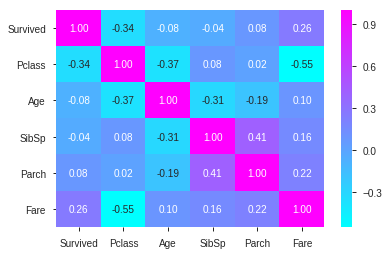

In [10]:
ht = sns.heatmap(train_data.iloc[:, 1:].corr(),
                annot=True, 
                fmt = ".2f", 
                cmap = "cool")
ht

### Sex to Survived

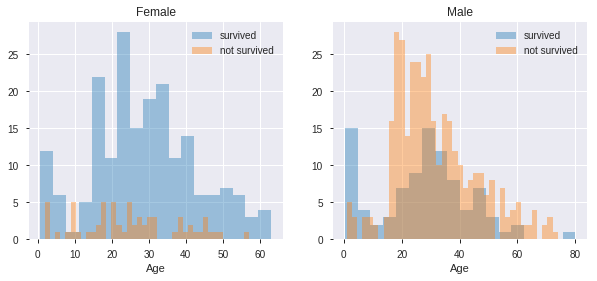

In [11]:
# do preliminary analysis of features to see which ones to use

survived = 'survived'
not_survived = 'not survived'

fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(10, 4))

women = train_data[train_data['Sex']=='female']
men = train_data[train_data['Sex']=='male']

ax = sns.distplot(women[women['Survived']==1].Age.dropna(), bins=18, label = survived, ax = axes[0], kde =False)
ax = sns.distplot(women[women['Survived']==0].Age.dropna(), bins=40, label = not_survived, ax = axes[0], kde =False)

ax.legend()
ax.set_title('Female')

ax = sns.distplot(men[men['Survived']==1].Age.dropna(), bins=18, label = survived, ax = axes[1], kde = False)
ax = sns.distplot(men[men['Survived']==0].Age.dropna(), bins=40, label = not_survived, ax = axes[1], kde = False)

ax.legend()
_ = ax.set_title('Male')


### Embarked to Survived

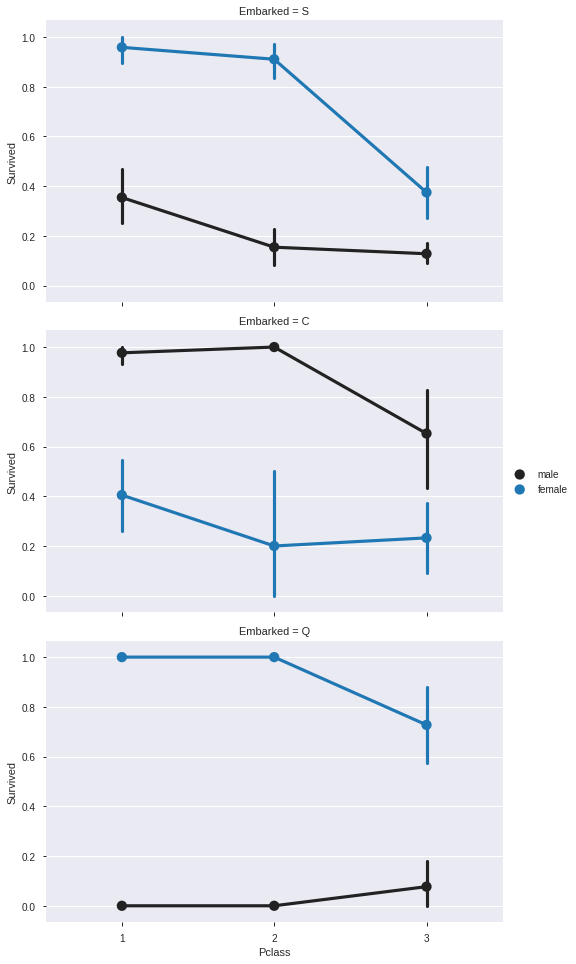

In [12]:
# women on port Q and S have a higher chance of survival
FacetGrid = sns.FacetGrid(train_data, row='Embarked', size=4.5, aspect=1.6)
FacetGrid.map(sns.pointplot, 'Pclass', 'Survived', 'Sex', palette=None,  order=None, hue_order=None )
FacetGrid.add_legend()

### Pclass to Survived

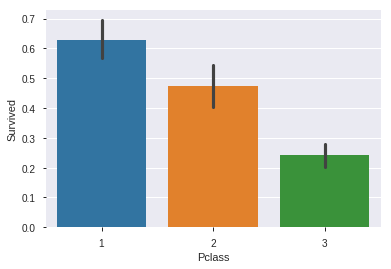

In [13]:
sns.barplot(x='Pclass', y='Survived', data=train_data)
#the higher the class the better probability of survival

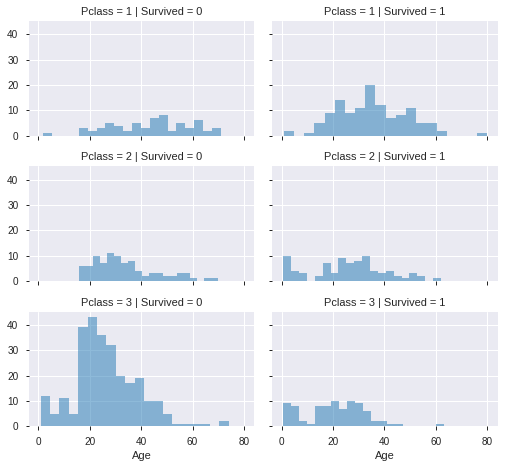

In [14]:
grid = sns.FacetGrid(train_data, col='Survived', row='Pclass', size=2.2, aspect=1.6)
grid.map(plt.hist, 'Age', alpha=.5, bins=20)
grid.add_legend();

<div id="4"></div>
# 4. Clean data: eliminate NaN & transform non-classifiable features
<div class="alert alert-block alert-info">
Takeaway: Use as many graphs as necessary to evaluate features & their correlations from all angles

### Fare
Fare is contingent on family size (Parch and SibSp) and Pclass features, since there are fares for multiple people

We have only one missing fare value in the test set, we will not touch the test set now

In [15]:
test_data['Fare'].isnull().values.any()

True

Filling the missing value in Fare with the median Fare of 3rd class alone passenger

mean_fare = test_data.groupby(['Pclass', 'Parch', 'SibSp']).['Fare'].mean()[3][0][0]

test_data['Fare'] = test_data['Fare'].fillna(mean_fare)

### SibSp, Parch -> Relatives

In [16]:
# SIBSP PARCH - create RELATIVES feature
data = [train_data, test_data]
for dataset in data:
    dataset['relatives'] = dataset['SibSp'] + dataset['Parch']
    dataset.loc[dataset['relatives'] > 0, 'not_alone'] = 0
    dataset.loc[dataset['relatives'] == 0, 'not_alone'] = 1
    dataset['not_alone'] = dataset['not_alone'].astype(int)
train_data['not_alone'].value_counts()

1    537
0    354
Name: not_alone, dtype: int64

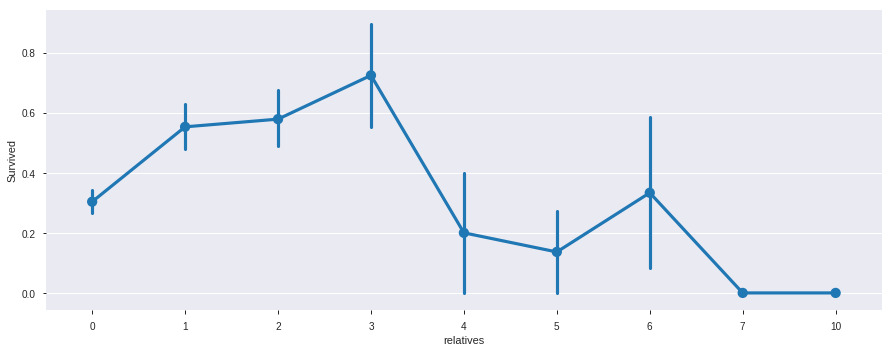

In [17]:
axes = sns.factorplot('relatives','Survived', 
                      data=train_data, aspect = 2.5, )
# higher probability of survival with 1 to 3 relatives (and in some cases with 6 relatives)

### PassengerID

In [18]:
# remove PASSENGERID from train set since it is irrelevant to predicted survival probability
train_data = train_data.drop(['PassengerId'], axis=1)

# but do not remove it from test set, since it is required for submission

### Cabin -> Deck
We have 687 missing cabin values in the training data only

By googling we find that only T cabin is present in the dataset, but there were rooms labeled as T, U, W, X, Y, Z, which are FEATURE VALUES ABSENT in the dataset provided except for T!

<div class="alert alert-block alert-info">
Takeaway: Use google to gain better understanding of the underlying structure of features that have a lot of missing values

In [19]:
# Transform CABIN feature - create a number feature "DECK" from it

import re
data = [train_data, test_data]

deck = {"A": 1, "B": 2, "C": 3, "D": 4, "E": 5, "F": 6, "G": 7, "U": 8}

for dataset in data:
    dataset['Cabin'] = dataset['Cabin'].fillna("U0")
    dataset['Deck'] = dataset['Cabin'].map(lambda x: re.compile("([a-zA-Z]+)").search(x).group())
    dataset['Deck'] = dataset['Deck'].map(deck)
    dataset['Deck'] = dataset['Deck'].fillna(0)
    dataset['Deck'] = dataset['Deck'].astype(int)
    
# we can now drop the cabin feature
train_data = train_data.drop(['Cabin'], axis=1)
test_data = test_data.drop(['Cabin'], axis=1)

In [20]:
train_data.head()
# cabin is now deck

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,relatives,not_alone,Deck
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,1,0,8
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,1,0,3
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,0,1,8
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S,1,0,3
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S,0,1,8


In [21]:
#train_data["Pclass"].values

### Pclass distribution in Decks

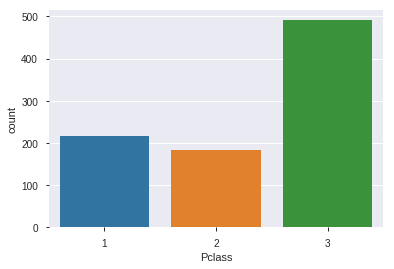

In [22]:
# Pclass value distribution
g = sns.countplot(train_data["Pclass"],order=[1,2,3])

In [23]:
def stacked_bars(feature):
    deck_1 = train_data[train_data['Deck']==1][feature].value_counts()
    deck_2 = train_data[train_data['Deck']==2][feature].value_counts()
    deck_3 = train_data[train_data['Deck']==3][feature].value_counts()
    deck_4 = train_data[train_data['Deck']==4][feature].value_counts()
    deck_5 = train_data[train_data['Deck']==5][feature].value_counts()
    deck_6 = train_data[train_data['Deck']==6][feature].value_counts()
    deck_7 = train_data[train_data['Deck']==7][feature].value_counts()
    deck_8 = train_data[train_data['Deck']==8][feature].value_counts()
    
    df = pd.DataFrame([deck_1, deck_2, deck_3, deck_4, deck_5, deck_6, deck_7, deck_8])
    df.index=['1','2','3','4','5','6','7','8']
    ax = df.plot(kind='bar',stacked=True,title='feature distribution')
    ax.set_xlabel("Decks")
    ax.set_ylabel(feature)

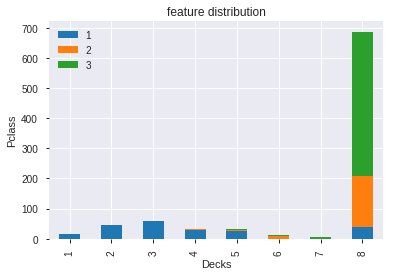

In [24]:
stacked_bars('Pclass')
# decks 1,2,3 are 100% first class
# so we see that most of 1st class passengers are on Decks 2 & 3

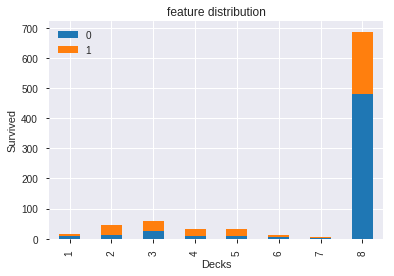

In [25]:
stacked_bars('Survived')
# 1 or blue means survived

### Age
Deal with missing AGE values is to create an array of random numbers within +- 1 std dev from the mean of all values.
<div class="alert alert-block alert-warning"> 
***TO DO: take median values of AGE according to Pclass groups, this would be an improvement***

***data.groupby(['Sex', 'Pclass']).median()['Age']***

In [26]:
# Missing AGE values: create an array of random numbers 
# computed based on the mean age in regards to the std dev and is_null

data = [train_data, test_data]

for dataset in data:
    mean = train_data["Age"].mean()
    std = test_data["Age"].std()
    is_null = dataset["Age"].isnull().sum()
    
    # compute random numbers between the mean, std and is_null
    # low, high, size
    rand_age = np.random.randint(mean - std, mean + std, size = is_null)
    
    # fill NaN values in Age column with random values generated
    age_slice = dataset["Age"].copy()
    age_slice[np.isnan(age_slice)] = rand_age
    dataset["Age"] = age_slice
    dataset["Age"] = train_data["Age"].astype(int)

train_data["Age"].isnull().sum()

0

### Embarked
fill EMBARKED missing values - fill in most common values.
<div class="alert alert-block alert-warning"> 
***TO DO: google info about passengers & get embarked values from results***

In [27]:
# EMBARKED feature has only two missing values - we fill these with the most common one
# which is 'S'

train_data['Embarked'].describe()

count     889
unique      3
top         S
freq      644
Name: Embarked, dtype: object

In [28]:
# EMBARKED fill in NaNs
common_value = 'S'
data = [train_data, test_data]

for dataset in data:
    dataset['Embarked'] = dataset['Embarked'].fillna(common_value)

<div id="5"></div>
# 5. Transform classifiable feature values to ints

In [29]:
train_data.info()
# now we have 4 categorical(object) features: Name, Sex, Ticket and Embarked

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
Survived     891 non-null int64
Pclass       891 non-null int64
Name         891 non-null object
Sex          891 non-null object
Age          891 non-null int64
SibSp        891 non-null int64
Parch        891 non-null int64
Ticket       891 non-null object
Fare         891 non-null float64
Embarked     891 non-null object
relatives    891 non-null int64
not_alone    891 non-null int64
Deck         891 non-null int64
dtypes: float64(1), int64(8), object(4)
memory usage: 90.6+ KB


### Embarked

In [30]:
# EMBARKED feature values to numeric
ports = {"S": 0, "C": 1, "Q": 2}
data = [train_data, test_data]

for dataset in data: 
    dataset['Embarked'] = dataset['Embarked'].map(ports)

### Age

In [31]:
# AGE feature values transform from float to int categories
data = [train_data, test_data]
for dataset in data:
    dataset['Age'] = dataset['Age'].astype(int)
    dataset.loc[ dataset['Age'] <= 11, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 11) & (dataset['Age'] <= 18), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 18) & (dataset['Age'] <= 22), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 22) & (dataset['Age'] <= 27), 'Age'] = 3
    dataset.loc[(dataset['Age'] > 27) & (dataset['Age'] <= 33), 'Age'] = 4
    dataset.loc[(dataset['Age'] > 33) & (dataset['Age'] <= 40), 'Age'] = 5
    dataset.loc[(dataset['Age'] > 40) & (dataset['Age'] <= 66), 'Age'] = 6
    dataset.loc[ dataset['Age'] > 66, 'Age'] = 6

In [32]:
# let's see how AGE is distributed 
train_data['Age'].value_counts()

4    169
6    165
5    144
3    136
2    113
1     96
0     68
Name: Age, dtype: int64

### Fare

In [33]:
# FARE transform from float to int
data = [train_data, test_data]
for dataset in data:
    dataset['Fare'] = dataset['Fare'].fillna(0)
    dataset['Fare'] = dataset['Fare'].astype(int)

In [34]:
# FARE 
data = [train_data, test_data]

for dataset in data:
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[(dataset['Fare'] > 31) & (dataset['Fare'] <= 99), 'Fare']   = 3
    dataset.loc[(dataset['Fare'] > 99) & (dataset['Fare'] <= 250), 'Fare']   = 4
    dataset.loc[ dataset['Fare'] > 250, 'Fare'] = 5
    dataset['Fare'] = dataset['Fare'].astype(int)

### Name -> Titles
<div class="alert alert-block alert-info"> 
Takeaway: We need to consider every single feature in terms of values & correlations w oth features.

<div class="alert alert-block alert-warning"> 
- ***TO DO: Master is a unique title because it is given only to male passengers below 26 with the highest survival rate. We can predict that all males titled Master whose entire family lives will live***
- ***TO DO: Predict die for all females whose entire family dies***
- ***TO DO: Is_Married is a potential NEW FEATURE since Mrs has the highest survival rate among females***

In [35]:
# from NAME extract TITLES to test a new feature
data = [train_data, test_data]
titles = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}

for dataset in data:
    # select Name column from each dataset & extract titles
    dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
    # replace titles with Rare or with one of 5 titles
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess', 'Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev',
                                                'Sir', 'Jonkheer', 'Dona'], 'Rare')
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')
    # convert titles to numbers
    dataset['Title'] = dataset['Title'].map(titles)
    # fill NaN with 0
    dataset['Title'] = dataset['Title'].fillna(0)
    
train_data = train_data.drop(['Name'], axis=1)
test_data = test_data.drop(['Name'], axis=1)

### Sex

In [36]:
# SEX convert to numeric
genders = {"male": 0, "female": 1}
data = [train_data, test_data]

for dataset in data:
    dataset['Sex'] = dataset['Sex'].map(genders)

### Ticket

In [37]:
# TICKET
train_data['Ticket'].describe()

#since there are 681 unique values, cannot convert them to useful categories

count          891
unique         681
top       CA. 2343
freq             7
Name: Ticket, dtype: object

In [38]:
# so we drop TICKET
train_data = train_data.drop(['Ticket'], axis=1)
test_data = test_data.drop(['Ticket'], axis=1)

In [39]:
train_data.describe()

# 38% have survived according to the train data set
# now there are no more missing values

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,relatives,not_alone,Deck,Title
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,0.352413,3.497194,0.523008,0.381594,1.523008,0.361392,0.904602,0.602694,6.936027,1.728395
std,0.486592,0.836071,0.477990,1.871952,1.102743,0.806057,1.250743,0.635673,1.613459,0.489615,2.074282,1.030039
min,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,2.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,1.000000
50%,0.000000,3.000000,0.000000,4.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,8.000000,1.000000
75%,1.000000,3.000000,1.000000,5.000000,1.000000,0.000000,2.000000,1.000000,1.000000,1.000000,8.000000,2.000000
max,1.000000,3.000000,1.000000,6.000000,8.000000,6.000000,5.000000,2.000000,10.000000,1.000000,8.000000,5.000000


<div id="6"></div>
# 6. Engineer new features

### NEW Age_Class

In [40]:
# AGE CLASS feature

data = [train_data, test_data]
for dataset in data:
    dataset['Age_Class'] = dataset['Age'] * dataset['Pclass']

### NEW Fare_Per_Person

In [41]:
# FARE / person feature

for dataset in data:
    dataset['Fare_Per_Person'] = dataset['Fare']/(dataset['relatives']+1)
    dataset['Fare_Per_Person'] = dataset['Fare_Per_Person'].astype(int)

<div id="7"></div>
# 7. Train ML models, tune hyperparams & evaluate

<div id="7.1."></div>
### 7.1. Look at preprocessed training data info

In [42]:
# Except for "Survived" column all the other columns possess predictive values
train_data.head(10)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,relatives,not_alone,Deck,Title,Age_Class,Fare_Per_Person
0,0,3,0,2,1,0,0,0,1,0,8,1,6,0
1,1,1,1,5,1,0,3,1,1,0,3,3,5,1
2,1,3,1,3,0,0,0,0,0,1,8,2,9,0
3,1,1,1,5,1,0,3,0,1,0,3,3,5,1
4,0,3,0,5,0,0,1,0,0,1,8,1,15,1
5,0,3,0,1,0,0,1,2,0,1,8,1,3,1
6,0,1,0,6,0,0,3,0,0,1,5,1,6,3
7,0,3,0,0,3,1,2,0,4,0,8,4,0,0
8,1,3,1,3,0,2,1,0,2,0,8,3,9,0
9,1,2,1,1,1,0,2,1,1,0,8,3,2,1


<div id="7.2."></div>
### 7.2. Prepare train & test datasets for model training

In [43]:
# for train data we drop the Survived column
X_train = train_data.drop("Survived", axis=1)
Y_train = train_data["Survived"]

# PassengerId is necessary for submission so we make a copy and delete PassengerId in this copy
X_test  = test_data.drop("PassengerId", axis=1).copy()

<div id="7.3."></div>
### 7.3 Train the models

<div id="dt"></div>
### Decision Tree

In [44]:
decision_tree = DecisionTreeClassifier()

# fit
decision_tree.fit(X_train, Y_train)

# predict
Y_pred_dt = decision_tree.predict(X_test)

# score
acc_decision_tree = round(decision_tree.score(X_train, Y_train) * 100, 2)

acc_decision_tree

92.59

CPU times: user 2 µs, sys: 2 µs, total: 4 µs
Wall time: 7.63 µs


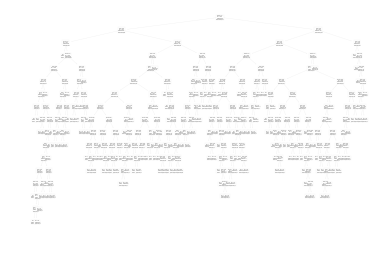

In [45]:
%time
tree.plot_tree(decision_tree);

<div id="rf"></div>
### Random Forest

In [46]:
random_forest = RandomForestClassifier(n_estimators=100)

# fit
random_forest.fit(X_train, Y_train)

# predict
Y_pred_rf = random_forest.predict(X_test)

# score
random_forest.score(X_train, Y_train)
acc_random_forest = round(random_forest.score(X_train, Y_train) * 100, 2)

acc_random_forest

92.59

<div id="lsvm"></div>
### Linear Support Vector Machine

In [47]:
linear_svc = LinearSVC()

# fit
linear_svc.fit(X_train, Y_train)

# predict
Y_pred_lsvm = linear_svc.predict(X_test)

# score
acc_linear_svc = round(linear_svc.score(X_train, Y_train) * 100, 2)

acc_linear_svc

81.71

<div id="svm"></div>
### Support Vector Machine Classifier

In [48]:
svm = SVC(C=5, random_state=42)

# fit
svm.fit(X_train, Y_train)

# predict
Y_pred_svm = svm.predict(X_test)

# score
acc_svm = round(svm.score(X_train, Y_train) * 100, 2)

acc_svm

89.11

<div id="lr"></div>
### Logistic Regression

In [49]:
logreg = LogisticRegression(C=5, penalty='l2',random_state=42)

# fit
logreg.fit(X_train, Y_train)

# predict
Y_pred_lr = logreg.predict(X_test)

# score
acc_log = round(logreg.score(X_train, Y_train) * 100, 2)

acc_log

81.71

<div id="knn"></div>
### K Nearest Neighbors

In [50]:
knn = KNeighborsClassifier(n_neighbors = 3)

# fit
knn.fit(X_train, Y_train)

# predict
Y_pred_knn = knn.predict(X_test)

# score
acc_knn = round(knn.score(X_train, Y_train) * 100, 2)

acc_knn

86.87

<div id="nb"></div>
### Gaussian Naive Bayes

In [51]:
gaussian = GaussianNB()

# fit
gaussian.fit(X_train, Y_train)

# predict
Y_pred_gnb = gaussian.predict(X_test)

# score
acc_gaussian = round(gaussian.score(X_train, Y_train) * 100, 2)

acc_gaussian

78.11

<div id="p"></div>
### Perceptron

In [52]:
perceptron = Perceptron(max_iter = 5)

# fit
perceptron.fit(X_train, Y_train)

# predict
Y_pred_p = perceptron.predict(X_test)

# score
acc_perceptron = round(perceptron.score(X_train, Y_train) * 100, 2)

acc_perceptron

81.48

<div id="sgd"></div>
### Stockastic Gradient Descent (SGD)

In [53]:
sgd = linear_model.SGDClassifier(max_iter=5, tol=None)

#fit
sgd.fit(X_train, Y_train)

#predict
Y_pred_sgd = sgd.predict(X_test)

#score
sgd.score(X_train, Y_train)
acc_sgd = round(sgd.score(X_train, Y_train) * 100, 2)

acc_sgd

50.06

<div id="dl"></div>
### DEEP LEARNING: TF, Keras, PyTorch

<div id="k"></div>
### Keras Artificial Neural Network

In [54]:
def build_ann(optimizer='adam'):
    
    # Initializing our ANN
    ann = Sequential()
    
    # Adding the input layer and the first hidden layer of our ANN with dropout
    ann.add(Dense(units=32, kernel_initializer='glorot_uniform', activation='relu', input_shape=(13,)))
    
    
    # Add other layers, it is not necessary to pass the shape because there is a layer before
    ann.add(Dense(units=64, kernel_initializer='glorot_uniform', activation='relu'))
    ann.add(Dropout(rate=0.5))
    ann.add(Dense(units=64, kernel_initializer='glorot_uniform', activation='relu'))
    ann.add(Dropout(rate=0.5))
    
    
    # Adding the output layer
    ann.add(Dense(units=1, kernel_initializer='glorot_uniform', activation='sigmoid'))
    
    # Compiling the ANN
    ann.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    
    return ann

In [55]:
# we divide training set(for which we have both x & y values) into X&Y subsets for Keras neural network
X_train_4nn, X_test_4nn, Y_train_4nn, Y_test_4nn = train_test_split(X_train, Y_train, 
                                                                    test_size=0.2, random_state=42)

In [56]:
opt = optimizers.Adam(lr=0.001)
ann = build_ann(opt)

# Fit ANN
history = ann.fit(X_train_4nn, Y_train_4nn, batch_size=16, epochs=30, 
                  validation_data=(X_test_4nn, Y_test_4nn))

Train on 712 samples, validate on 179 samples
Epoch 1/30
712/712 [==============================] - 1s 739us/step - loss: 0.8520 - accuracy: 0.5506 - val_loss: 0.6085 - val_accuracy: 0.7039
Epoch 2/30
712/712 [==============================] - 0s 125us/step - loss: 0.6618 - accuracy: 0.6292 - val_loss: 0.5629 - val_accuracy: 0.7709
Epoch 3/30
712/712 [==============================] - 0s 129us/step - loss: 0.6364 - accuracy: 0.6419 - val_loss: 0.5386 - val_accuracy: 0.7709
Epoch 4/30
712/712 [==============================] - 0s 127us/step - loss: 0.5782 - accuracy: 0.6868 - val_loss: 0.5217 - val_accuracy: 0.7318
Epoch 5/30
712/712 [==============================] - 0s 134us/step - loss: 0.5674 - accuracy: 0.7275 - val_loss: 0.4994 - val_accuracy: 0.7598
Epoch 6/30
712/712 [==============================] - 0s 136us/step - loss: 0.5337 - accuracy: 0.7598 - val_loss: 0.4820 - val_accuracy: 0.7654
Epoch 7/30
712/712 [==============================] - 0s 121us/step - loss: 0.5025 - accur

,0,1,accuracy,macro avg,weighted avg
precision,0.82,0.82,0.82,0.82,0.82
recall,0.89,0.73,0.82,0.81,0.82
f1-score,0.85,0.77,0.82,0.81,0.82
support,105.00,74.00,0.82,179.00,179.00


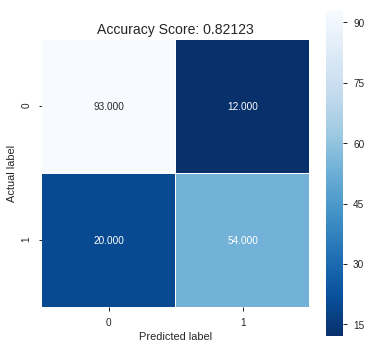

In [57]:
# Predict
ann_prediction = ann.predict(X_test_4nn)
ann_prediction = (ann_prediction > 0.5) # convert probabilities to binary output

# Score - compute error between predicted data and true response and display it in confusion matrix
score = metrics.accuracy_score(Y_test_4nn, ann_prediction)
display_confusion_matrix(Y_test_4nn, ann_prediction, score=score)

<div id="tf"></div>
### TensorFlow

In [58]:
# we divide training set(for which we have both x & y values) into X&Y subsets for TensorFlow NN
X_train_4tf, X_test_4tf, Y_train_4tf, Y_test_4tf = train_test_split(X_train, Y_train, 
                                                                    test_size=0.2, random_state=42)

In [59]:
train_data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,relatives,not_alone,Deck,Title,Age_Class,Fare_Per_Person
0,0,3,0,2,1,0,0,0,1,0,8,1,6,0
1,1,1,1,5,1,0,3,1,1,0,3,3,5,1
2,1,3,1,3,0,0,0,0,0,1,8,2,9,0
3,1,1,1,5,1,0,3,0,1,0,3,3,5,1
4,0,3,0,5,0,0,1,0,0,1,8,1,15,1


In [60]:
Pclass = tf.feature_column.numeric_column("Pclass")
Sex = tf.feature_column.numeric_column("Sex")
Age = tf.feature_column.numeric_column("Age")
SibSp = tf.feature_column.numeric_column("SibSp")
Parch = tf.feature_column.numeric_column("Parch")
Fare = tf.feature_column.numeric_column("Fare")
Embarked = tf.feature_column.numeric_column("Embarked")
relatives = tf.feature_column.numeric_column("relatives")
not_alone = tf.feature_column.numeric_column("not_alone")
Deck = tf.feature_column.numeric_column("Deck")
Title = tf.feature_column.numeric_column("Title")
Age_Class = tf.feature_column.numeric_column("Age_Class")
Fare_Per_Person = tf.feature_column.numeric_column("Fare_Per_Person")

feat_cols = [Pclass, Sex, Age, SibSp, Parch, Fare, Embarked, relatives, not_alone, Deck,
             Title, Age_Class, Fare_Per_Person]

In [61]:
input_func=tf.compat.v1.estimator.inputs.pandas_input_fn(x=X_train_4tf,
                                               y=Y_train_4tf,
                                               batch_size=100,
                                               num_epochs=None,
                                               shuffle=True)

model = tf.estimator.LinearClassifier(feature_columns = feat_cols)

In [62]:
%%time
# 10000 steps so that it doesn't run forever
model.train(input_fn=input_func, max_steps=10000)

pred_fn = tf.compat.v1.estimator.inputs.pandas_input_fn(x=X_test_4tf,batch_size=len(X_test_4tf),shuffle=False)

predictions = list(model.predict(input_fn=pred_fn))
final_preds = []
for pred in predictions:
    final_preds.append(pred['class_ids'][0])
    
from sklearn.metrics import classification_report
print(classification_report(Y_test_4tf,final_preds))

              precision    recall  f1-score   support

           0       0.82      0.84      0.83       105
           1       0.76      0.74      0.75        74

    accuracy                           0.80       179
   macro avg       0.79      0.79      0.79       179
weighted avg       0.80      0.80      0.80       179

CPU times: user 1min 1s, sys: 4.13 s, total: 1min 6s
Wall time: 44.1 s


<div id="gb"></div>
### Gradient Boosting

In [63]:
gb = GradientBoostingClassifier(
            #loss='exponential',
            n_estimators=1000,
            learning_rate=0.1,
            max_depth=3,
            subsample=0.5,
            random_state=0).fit(X_train, Y_train)

# fit
gb.fit(X_train, Y_train)

# predict
Y_pred_gb = gb.predict(X_test)

# score
gb_acc = round(gb.score(X_train, Y_train) * 100, 2)

gb_acc

91.81

<div id="xgb"></div>
### XGBoost - Extreme Gradient Boosting

In [64]:
xgb = XGBClassifier(max_depth=5, learning_rate=0.1, n_jobs=-1, nthread=-1, 
                    gamma=0.06, min_child_weight=5, 
                    subsample=1, colsample_bytree=0.9, 
                    reg_alpha=0, reg_lambda=0.5, 
                    random_state=42)

# fit
xgb.fit(X_train, Y_train)

# predict
Y_pred_xgb = xgb.predict(X_test)

# score
xgb_acc = round(xgb.score(X_train, Y_train) * 100, 2)

xgb_acc

86.98

<div id="lgbm"></div>
### LightGBM

In [65]:
lgbm = LGBMClassifier(num_leaves=31, learning_rate=0.1, 
                      n_estimators=64, random_state=42, n_jobs=-1)

# fit
lgbm.fit(X_train, Y_train)

# predict
Y_pred_lgbm = lgbm.predict(X_test)
    
# score
lgbm_acc = round(lgbm.score(X_train, Y_train) * 100, 2)

lgbm_acc 

89.56

<div id="ensemble"></div>
### ENSEMBLE LEARNING: Bagging, Boosting, Stacking
Bagging will mainly focus at getting an ensemble model with less variance than its components 

boosting and stacking will mainly try to produce strong models less biased than their components (even if variance can also be reduced).
<div id="stacking"></div>
### Model Stacking

In [66]:
# We pick some of the best performing models to be the first layer of the stack 
# XGB is set at layer 2 to make the final prediction

# we divide our training set for which we have both x & y values into subsets - X&Y for stacking
X_train_4s, X_test_4s, Y_train_4s, Y_test_4s = train_test_split(X_train, Y_train, test_size=0.2)

In [67]:
# select several models
models = [random_forest, knn, lgbm]

# perform stacking
S_train, S_test = stacking(models,
                           X_train_4s, Y_train_4s, X_test_4s,
                           regression=False,
                           mode='oof_pred_bag',
                           n_folds=5,
                           save_dir=None,
                           needs_proba=False,
                           random_state=42,
                           stratified=True,
                           shuffle=True,
                           verbose=2
                          )

task:         [classification]
n_classes:    [2]
metric:       [accuracy_score]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [RandomForestClassifier]
    fold  0:  [0.75524476]
    fold  1:  [0.80419580]
    fold  2:  [0.81118881]
    fold  3:  [0.85915493]
    fold  4:  [0.80141844]
    ----
    MEAN:     [0.80624055] + [0.03302248]
    FULL:     [0.80617978]

model  1:     [KNeighborsClassifier]
    fold  0:  [0.73426573]
    fold  1:  [0.73426573]
    fold  2:  [0.76923077]
    fold  3:  [0.83802817]
    fold  4:  [0.72340426]
    ----
    MEAN:     [0.75983893] + [0.04204099]
    FULL:     [0.75983146]

model  2:     [LGBMClassifier]
    fold  0:  [0.76923077]
    fold  1:  [0.81118881]
    fold  2:  [0.83216783]
    fold  3:  [0.86619718]
    fold  4:  [0.77304965]
    ----
    MEAN:     [0.81036685] + [0.03654514]
    FULL:     [0.81039326]



In [68]:
# Fit the 2nd level model on the output of level 1
xgb.fit(S_train, Y_train_4s)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9, gamma=0.06,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=5, missing=None, n_estimators=100, n_jobs=-1,
              nthread=-1, objective='binary:logistic', random_state=42,
              reg_alpha=0, reg_lambda=0.5, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [69]:
# Make predictions on the localized test set
stacked_pred = xgb.predict(S_test)
print('Final prediction score: [%.8f]' % accuracy_score(Y_test_4s, stacked_pred))

Final prediction score: [0.87150838]


<div id="7.4."></div>
### 7.4. Score the models

In [70]:
results = pd.DataFrame({
    'Model': ['Support Vector Machines', 'KNN', 'Logistic Regression', 
              'Random Forest', 'Naive Bayes', 'Perceptron', 
              'Stochastic Gradient Decent', 
              'Decision Tree'],
    'Score': [acc_linear_svc, acc_knn, acc_log, 
              acc_random_forest, acc_gaussian, acc_perceptron, 
              acc_sgd, acc_decision_tree]})
result_data = results.sort_values(by='Score', ascending=False)
result_data = result_data.set_index('Score')
result_data.head(9)

,Model
Score,
92.59,Random Forest
92.59,Decision Tree
86.87,KNN
81.71,Support Vector Machines
81.71,Logistic Regression
81.48,Perceptron
78.11,Naive Bayes
50.06,Stochastic Gradient Decent


<div id="7.5."></div>
### 7.5. K-Fold Cross Validation

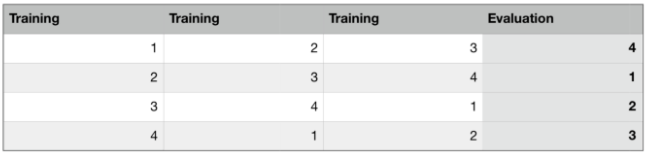

In [71]:
# training data is split into K subsets (folds)
# model is trained and evaluated K times

# the following code performs cross-validation 10 times
from sklearn.model_selection import cross_val_score
rf = RandomForestClassifier(n_estimators=100)
scores = cross_val_score(rf, X_train, Y_train, cv=10, scoring='accuracy')

print("Scores:", scores)
print("Mean:", scores.mean())
print("Standard Deviation:", scores.std())

Scores: [0.75555556 0.83333333 0.75280899 0.86516854 0.87640449 0.86516854
 0.84269663 0.7752809  0.85393258 0.86363636]
Mean: 0.8283985926682556
Standard Deviation: 0.04579572137885786


<div id="7.6."></div>
### 7.6. Feature importance

In [72]:
# measure feature importance for the best model 
# tune features to further improve best model score
# more features - more likely model will be overfit
importances = pd.DataFrame({'feature':X_train.columns,'importance':np.round(random_forest.feature_importances_,3)})
importances = importances.sort_values('importance',ascending=False).set_index('feature')
importances.head(15)

,importance
feature,
Title,0.205
Sex,0.177
Age_Class,0.092
Deck,0.083
Pclass,0.073
Age,0.071
relatives,0.067
Fare,0.064
Embarked,0.053


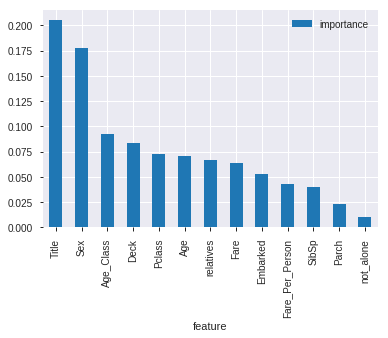

In [73]:
importances.plot.bar()

In [74]:
# not_alone and Parch are not important in random forest predictions.
# we drop them and see updated results
train_data  = train_data.drop("not_alone", axis=1)
test_data  = test_data.drop("not_alone", axis=1)

train_data  = train_data.drop("Parch", axis=1)
test_data  = test_data.drop("Parch", axis=1)

<div id="7.7."></div>
### 7.7. Random Forest 2nd test (after removing unimportant features)

In [75]:
# this time set out of bag samples to true
random_forest2 = RandomForestClassifier(n_estimators=100, oob_score = True)

# fit
random_forest2.fit(X_train, Y_train)

# predict
Y_pred_rf2 = random_forest2.predict(X_test)

# score
random_forest2.score(X_train, Y_train)
acc_random_forest2 = round(random_forest2.score(X_train, Y_train) * 100, 2)

acc_random_forest2

92.59

<div id="7.8."></div>
### 7.8. Out of bag samples (instead of K-fold CV) to eval RF classifier

In [77]:
print("oob score:", round(random_forest2.oob_score_, 4)*100, "%")

oob score: 82.04 %


<div id="7.9."></div>
### 7.9. Hyperparameter Tuning

In [78]:
# takes a long time to tune
# %%time

In [ ]:
param_grid = { "criterion" : ["gini", "entropy"], 
              "min_samples_leaf" : [1, 5, 10, 25, 50, 70], 
              "min_samples_split" : [2, 4, 10, 12, 16, 18, 25, 35], 
              "n_estimators": [100, 400, 700, 1000, 1500]}

from sklearn.model_selection import GridSearchCV, cross_val_score

rf = RandomForestClassifier(n_estimators=100, max_features='auto', oob_score=True, random_state=1, n_jobs=-1)

clf = GridSearchCV(estimator=rf, param_grid=param_grid, n_jobs=-1)

clf.fit(X_train, Y_train)

#now it is called best_params
clf.best_params_

<div id="7.10."></div>
### 7.10. Test model with best_params_ from GridSearchCV

In [ ]:
# Random Forest w best params
random_forest_b_p = RandomForestClassifier(criterion = "gini", 
                                       min_samples_leaf = 1, 
                                       min_samples_split = 10,   
                                       n_estimators=100, 
                                       max_features='auto', 
                                       oob_score=True, 
                                       random_state=1, 
                                       n_jobs=-1)

random_forest_b_p.fit(X_train, Y_train)
Y_pred_b_p = random_forest_b_p.predict(X_test)

random_forest_b_p.score(X_train, Y_train)

print("oob score:", round(random_forest_b_p.oob_score_, 4)*100, "%")

<div id="7.11."></div>
### 7.11. Evaluate model with Confusion Matrix

In [ ]:
# Evaluation of a classification model is more complicated than eval of a regression model
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
predictions = cross_val_predict(random_forest_b_p, X_train, Y_train, cv=3)
confusion_matrix(Y_train, predictions)

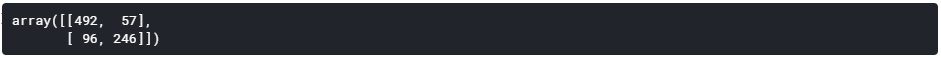
The first row is about the not-survived-predictions: 
- 492 passengers were correctly classified as not survived (called true negatives) 
- 57 where wrongly classified as not survived (false positives).


The second row is about the survived-predictions: 
- 96 passengers where wrongly classified as survived (false negatives) 
- 246 where correctly classified as survived (true positives).

<div id="7.12."></div>
### 7.12. Precision and Recall

In [ ]:
from sklearn.metrics import precision_score, recall_score

print("Precision:", precision_score(Y_train, predictions))
print("Recall:",recall_score(Y_train, predictions))

# Our model predicts 81% of the time, a passengers survival correctly (precision). 
# The recall tells us that it predicted the survival of 72 % of the people who actually survived.

<div id="7.13."></div>
### 7.13. F-Score

In [ ]:
# You can combine precision and recall into one score, which is called the F-score. 
# The F-score is computed with the harmonic mean of precision and recall. 
# Note that it assigns much more weight to low values. 
# As a result of that, the classifier will only get a high F-score, if both recall and precision are high.

from sklearn.metrics import f1_score
f1_score(Y_train, predictions)

<div id="7.14."></div>
### 7.14. Precision Recall Curve
For each person the Random Forest algorithm has to classify, it computes a probability based on a function and it classifies the person as survived (when the score is bigger the than threshold) or as not survived (when the score is smaller than the threshold). That’s why the threshold plays an important part.

In [ ]:
from sklearn.metrics import precision_recall_curve

# getting the probabilities of our predictions
y_scores = random_forest_b_p.predict_proba(X_train)
y_scores = y_scores[:,1]

precision, recall, threshold = precision_recall_curve(Y_train, y_scores)
def plot_precision_and_recall(precision, recall, threshold):
    plt.plot(threshold, precision[:-1], "r-", label="precision", linewidth=5)
    plt.plot(threshold, recall[:-1], "b", label="recall", linewidth=5)
    plt.xlabel("threshold", fontsize=19)
    plt.legend(loc="upper right", fontsize=19)
    plt.ylim([0, 1])

plt.figure(figsize=(14, 7))
plot_precision_and_recall(precision, recall, threshold)
plt.show()


<div id="7.15."></div>
### 7.15. ROC AUC Curve
This curve plots the true positive rate (also called recall) against the false positive rate (ratio of incorrectly classified negative instances), instead of plotting the precision versus the recall.

In [ ]:
from sklearn.metrics import roc_curve
# compute true positive rate and false positive rate
false_positive_rate, true_positive_rate, thresholds = roc_curve(Y_train, y_scores)
# plotting them against each other
def plot_roc_curve(false_positive_rate, true_positive_rate, label=None):
    plt.plot(false_positive_rate, true_positive_rate, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'r', linewidth=4)
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate (FPR)', fontsize=16)
    plt.ylabel('True Positive Rate (TPR)', fontsize=16)

plt.figure(figsize=(14, 7))
plot_roc_curve(false_positive_rate, true_positive_rate)
plt.show()

### ROC AUC (True Positive Rate Area Under Curve) Score
A classifiers that is 100% correct would have a ROC AUC Score of 1 
and a completely random classiffier would have a score of 0.5.

In [ ]:
from sklearn.metrics import roc_auc_score
r_a_score = roc_auc_score(Y_train, y_scores)
print("ROC-AUC-Score:", r_a_score)

<div id="7.16."></div>
### 7.16. Potential next steps to improve score
<div class="alert alert-block alert-warning"> 
- feature engineering. removing unimportant features
- hyperparameter tuning
- ensemble learning

<div id="8"></div>
# 8. Export output to csv & submit

In [ ]:
## output set up to use predictions_rfc
output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': Y_pred_b_p})

## output to be saved in csv
output.to_csv('my_submission.csv', index=False)
print("Your submission was successfully saved!")

<div id="9"></div>
# 9. Important non-obvious lessons
<div class="alert alert-block alert-info"> 
#### Key Takeaways on feature engineering: 
- We need to consider every single feature in terms of values & correlations w oth features. For example the Master is a unique title because it is given only to male passengers below 26 with the highest survival rate
- Raw data EDA is the fastest way to generate first feature hypotheses
- Use as many graphs as necessary to evaluate features & their correlations from all angles
- Use google to gain better understanding of the underlying structure of features that have a lot of missing values
- We need to consider every single feature in terms of values & correlations w oth features

<div id="10"></div>
# 10. References:
<div class="alert alert-block alert-success">  
#### Feature engineering
- https://www.kaggle.com/alexisbcook/titanic-tutorial
- https://towardsdatascience.com/predicting-the-survival-of-titanic-passengers-30870ccc7e8
- https://www.kaggle.com/gunesevitan/titanic-advanced-feature-engineering-tutorial
- https://www.kaggle.com/abhinand05/machine-learning-for-everyone-lb-top-5

#### Efficient use of pandas, sklearn libries
- https://www.kaggle.com/parulpandey/10-simple-hacks-to-speed-up-your-data-analysis
- https://www.kaggle.com/python10pm/pandas-100-tricks
- https://www.kaggle.com/python10pm/sklearn-27-best-tips-and-tricks

#### Hyper-Parameter Optimization
- https://medium.com/@cjl2fv/an-intro-to-hyper-parameter-optimization-using-grid-search-and-random-search-d73b9834ca0a


#### Ensemble models
- https://www.kaggle.com/pliptor/how-am-i-doing-with-my-score
- https://www.kaggle.com/yassineghouzam/titanic-top-4-with-ensemble-modeling
- https://www.kaggle.com/ldfreeman3/a-data-science-framework-to-achieve-99-accuracy
- https://www.kaggle.com/erikbruin/titanic-2nd-degree-families-and-majority-voting
- https://www.kaggle.com/nhlr21/complete-titanic-tutorial-with-ml-nn-ensembling
- https://www.kaggle.com/vanshjatana/applied-machine-learning
- https://towardsdatascience.com/ensemble-methods-bagging-boosting-and-stacking-c9214a10a205

#### ML
- https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
- https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html
- https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html
- https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
- https://scikit-learn.org/stable/modules/grid_search.html
- https://xgboost.readthedocs.io/en/latest/

#### Neural networks
- https://elitedatascience.com/keras-tutorial-deep-learning-in-python
- https://www.tensorflow.org/tutorials/keras/classification
- https://keras.io/